### İş Problemi:

El yapımı kışlık ürünler satan bir firma, 
sarı ve yeşil buton renklerinin online reklam kampanyalarında farklı dönüşüm oranlarına sahip olup olmadığını analiz etmek istemektedir. 

Firmanın hedefi, hangi bere renginin kullanıcılar üzerinde daha fazla etkileşim yarattığını ve dönüşüm oranlarını artırdığını belirleyerek,
reklam stratejisini optimize etmektir.

Firma, sarı ve yeşil olmak üzere iki farklı bere rengini kullanarak reklam kampanyaları düzenlemiştir. 
Kampanyalar boyunca tıklama sayısı, görüntülenme sayısı, satın alma sayısı  ve ortalama kazanç verileri toplanmıştır. 

#### Çözüm Yaklaşımı:

Reklam stratejisini optimize etmek ve doğru stratejiye karar vermek için, hem ortalamalar hem de oranlar üzerinden AB testi yapılacaktır.

##### Veri Setindeki Değişkenlerin Açıklamaları:

In [824]:
#color: "Yeşil" ve "Sarı" bere rengini ifade eder.

#color_count: Gösterim sayısı- (impression). Bere görselinin kullanıcılar tarafından kaç kez görüntülendiğini gösterir.

#click_count: Tıklama sayısı. Bere görselinin  kaç kere tıklandığını ifade eder.

#purchase_count: Satın alma sayısıdır. Kullanıcıların bir reklam ya da ürüne tıkladıktan sonra gerçekleştirdiği satın alım sayısını ifade eder.

#avg_revenue: Ortalama geliri ifade eder. 

In [4]:
# Veri Analizi ve nümerik hesaplamalar ile İlgili olan Kütüphaneler
import pandas as pd
import numpy as np

# Veri Görselleştirme ile ilgili olan Kütüphaneler
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express


# AB Testi İle İlgili Olan Kütüphaneler
from scipy import stats
from statsmodels.stats import proportion as pr
import statsmodels.stats.api as sms
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu 
from statsmodels.stats.proportion import proportions_ztest

# Çıktı görüntüleme/uyarı  ayarları
import warnings
warnings.filterwarnings ("ignore")
pd.set_option ('display.float_format', lambda x: '%.6f' % x)
pd.set_option ('display.width', None)
pd.set_option ('display.max_columns', None)


In [6]:
#Veri Seti Yükleme
df = pd.read_excel("/Users/bernaersari/PycharmProjects/DS_BOOTCAMP/Denemeler/abtest/gugiko_ab_test.xlsx")


#### Veriye Hızlı Bakış Atalım

In [8]:
def check_df(dataframe, head=5):
    print("##################### Columns #####################")
    print(dataframe.columns)
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head())
    print("##################### Tail #####################")
    print(dataframe.tail())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### DESCRIBE #####################")
    print(dataframe.describe())

check_df(df)

##################### Columns #####################
Index(['day', 'color', 'color_count', 'click_count', 'purchase_count',
       'avg_revenue(euro)'],
      dtype='object')
##################### Shape #####################
(120, 6)
##################### Types #####################
day                    int64
color                 object
color_count            int64
click_count            int64
purchase_count         int64
avg_revenue(euro)    float64
dtype: object
##################### Head #####################
   day               color  color_count  click_count  purchase_count  \
0    1   green knit beanie           30           10              10   
1    1  yellow knit beanie           25           12               9   
2    2   green knit beanie           20           10               6   
3    2  yellow knit beanie           30           20              13   
4    3   green knit beanie           15           15               9   

   avg_revenue(euro)  
0         128.500000  
1

In [10]:
#color sütunu içindeki değerleri kısaltalım. Sadece renk ile ifade edilmesi yeterli olacaktır. 
# color_count değişken ismini de impression olarak değiştirelim.

df["color"] = df["color"].replace({"yellow knit beanie": "yellow",
                                "green knit beanie":"green"})
df = df.rename(columns={'color_count': 'impression'})

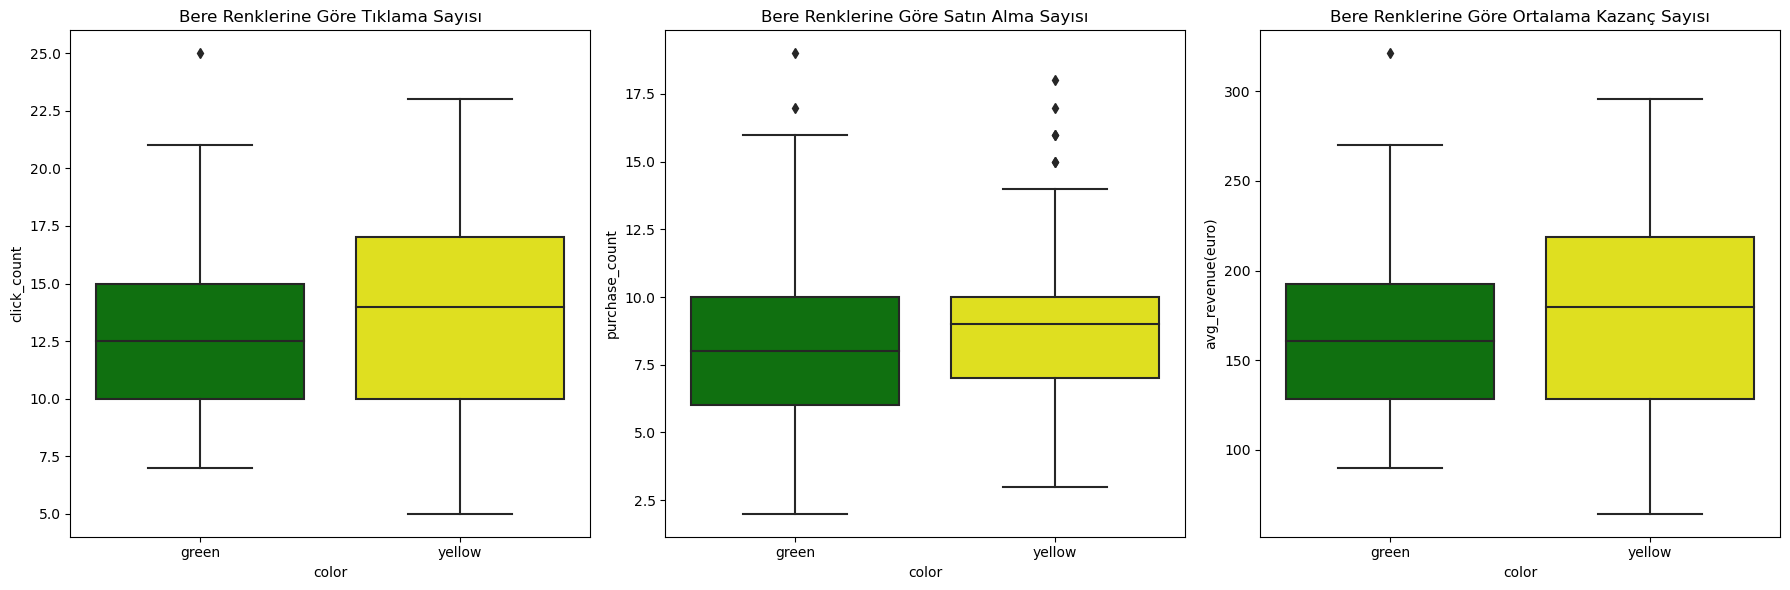

In [854]:
#Grafik için renk seçimi
palette = {'yellow': 'yellow', 'green': 'green'}

# Boxplot oluşturma
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Tıklama sayısı için box plot
sns.boxplot(x='color', y='click_count', data=df, ax=axes[0],palette=palette)
axes[0].set_title('Bere Renklerine Göre Tıklama Sayısı')

# Satın alma sayısı için box plot
sns.boxplot(x='color', y='purchase_count', data=df, ax=axes[1],palette=palette)
axes[1].set_title('Bere Renklerine Göre Satın Alma Sayısı')

# Kazanç için box plot
sns.boxplot(x='color', y='avg_revenue(euro)', data=df, ax=axes[2],palette=palette)
axes[2].set_title('Bere Renklerine Göre Ortalama Kazanç Sayısı')

plt.tight_layout()
plt.show()

In [835]:
#Satın Alma Sayısı Grafiği'ne göre, birkaç aykırı gözlem sayısı görülmektedir. Baskılama,silme ya da veri setinde bırakma gibi seçenekler
#değerlendirilebilir. Çok fazla olmadığı için veri setinde bırakmayı tercih ediyorum.

##### Veri setine ekleyeceğimiz metrikler:

In [ ]:
#click_rate: Tıklama oranı. Click Through Rate (CTR) olarak da bilinir ve tıklama sayısının gösterim sayısına oranıdır.
#purchase_rate: Satın alma oranı. Genellikle Conversion Rate (CR) olarak bilinir ve satın alma sayısının gösterim sayısına oranıdır. 

In [860]:
df["click_rate"]=df["click_count"]/df["impression"]*100

In [862]:
df["purchase_rate"]=df["purchase_count"]/df["impression"]*100

In [864]:
df.head(4) # Hesaplanmış iki sütunun da dataframe e eklenmiş olduğunu görüyoruz.

,day,color,impression,click_count,purchase_count,avg_revenue(euro),click_rate,purchase_rate
0,1,green,30,10,10,128.500000,33.333333,33.333333
1,1,yellow,25,12,9,154.200000,48.000000,36.000000
2,2,green,20,10,6,128.500000,50.000000,30.000000
3,2,yellow,30,20,13,257.000000,66.666667,43.333333


##### Pivot tablo ile sarı ve yeşil berelere göre tıklanma ve satın alma oran dağılımlarına da bakalım.

In [866]:
pivot_click_rate = df.pivot(index='day', columns='color', values='click_rate')

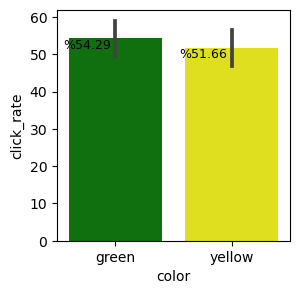

In [868]:
colors = ['green', 'yellow']
plt.figure(figsize=(3, 3))
ax=sns.barplot(x='color', y='click_rate', data=df, palette=colors)
for p in ax.patches:
    ax.annotate(f'%{p.get_height():.2f}', (p.get_x() + p.get_width() / 5., p.get_height()),
                ha='center', va='top', fontsize=9, color='black') 
plt.show()

In [870]:
pivot_purchase_rate = df.pivot(index='day', columns='color', values='purchase_rate')

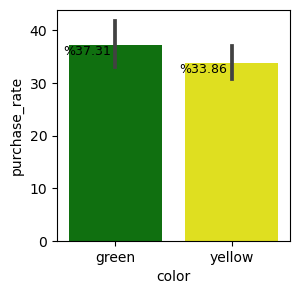

In [872]:
colors = ['green', 'yellow']
plt.figure(figsize=(3, 3))
ax=sns.barplot(x='color', y='purchase_rate', data=df, palette=colors)
for p in ax.patches:
    ax.annotate(f'%{p.get_height():.2f}', (p.get_x() + p.get_width() / 5., p.get_height()),
                ha='center', va='top', fontsize=9, color='black') 
plt.show()

In [874]:
# Sarı ve yeşil bere olarak değerleri ayıralım.
yellow_data = df[df['color'] == 'yellow']
green_data = df[df['color'] == 'green']

In [876]:
print("yellow- Click Mean:", yellow_data["click_count"].mean())
print("green- Click Mean:", green_data["click_count"].mean())

yellow- Click Mean: 13.483333333333333
green- Click Mean: 13.083333333333334


Genel olarak, yeşil ve sarı bere ile ilgili grafiklere baktığımızda bazı farklılıklar olduğu görülüyor. 
Bu farklılıkların istatiksel olarak anlamlı olup olmadığına bakmak için AB testi yapılır.

#### AB TEST ORTALAMA KARŞILAŞTIRMA

In [803]:
# İKİ GRUP FARKLILIKLARINI KARŞILAŞTIRMAK İÇİN "BAĞIMSIZ ÖRNEKLEM T TESTİ" YA DA  "MANN WHITNEY U TESTI" KULLANILIR.
# "BAĞIMSIZ ÖRNEKLEM T TESTİ"İÇİN 2 VARSAYIMIN SAĞLANMASI GEREKMEKTEDİR. BU VARSAYIMLAR:

# 1.Varsayım: "Normallik Varsayımı"--Verilerin normal dağılıma uygun olması anlamına gelir. 
# Normal dağılım, çan eğrisi olarak bilinen simetrik bir dağılım şeklidir.
# Saphiro-Wilk Testi ile kontrol edilir.

# 2.Varsayım "Varyans Homojenliği Varsayımı"--Farklı gruplardaki verilerin varyanslarının (dağılımlarının) eşit olması anlamına gelir. 
# Gruplar arasındaki değişkenlik benzer olmalıdır.
# Levene Testi ile kontrol edilir.

## EĞER NORMALLİK VARSAYIMI SAĞLANMIYORSA, DİREKT "MANN WHITNEY U TESTI" KULLANILIR.
## EĞER NORMALLİK VARSAYIMI SAĞLANIYORSA, HOMOJENLİK VARSAYIMINA GEÇİLİR. 
                                          #EĞER VARYANS HOMOJENLİĞİ SAĞLANIYORSA, "BAĞIMSIZ ÖRNEKLEM T TESTİ" KULLANILIR.
                                          #EĞER VARYANS HOMOJENLİĞİ SAĞLANMIYORSA,"BAĞIMSIZ ÖRNEKLEM T TESTİ-(WELCH)" KULLANILIR.

#### 1.HİPOTEZ TESTİ: TIKLAMA ORTALAMALARI

Hipotez testlerimizi H0-fark yoktur ve H1-fark vardır üzerinden oluşturalım.

H0 : M1 = M2 Yeşil bere görseli ile sarı bere görseli tıklanma ortalamaları arasında fark yoktur.

H1 : M1!= M2 Yeşil bere ve sarı bere görseli tıklanma ortalamaları arasında fark vardır.

In [ ]:
#Bu hipotez testini yapmak için ilk önce normallik varsayımına bakalım.

##### 1.1.NORMALLİK VARSAYIMI(SHAPIRO-WILK TESTİ)

H0 : Normal dağılım varsayımı sağlanmaktadır.

H1 : Normal dağılım varsayımı sağlanmamaktadır.

In [882]:
#Shapiro-Wilk Testi
test_stat, green_pvalue = shapiro(green_data["click_count"])
print('Green_Test Stat = %.4f, green_p-value = %.4f' % (test_stat, green_pvalue)) #normallik varsayımı için shapiro-wilk testi kullanılır.
test_stat, yellow_pvalue = shapiro(yellow_data["click_count"])
print('Yellow_Test Stat = %.4f, yellow_p-value = %.4f' % (test_stat, yellow_pvalue))

Green_Test Stat = 0.9339, green_p-value = 0.0029
Yellow_Test Stat = 0.9825, yellow_p-value = 0.5419


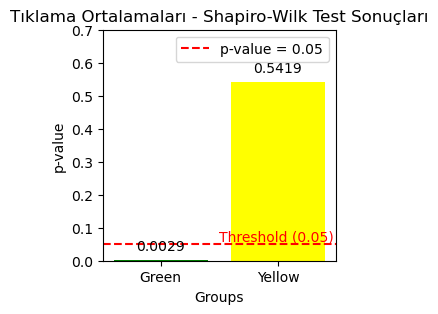

In [916]:
#Shapiro-Wilk Testi-p_value değeri için Bar Grafiği
groups = ['Green', 'Yellow']
p_values = [green_pvalue, yellow_pvalue]
plt.figure(figsize=(3, 3))
bars = plt.bar(groups, p_values, color=['green', 'yellow'])
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.title('Tıklama Ortalamaları - Shapiro-Wilk Test Sonuçları')
plt.ylabel('p-value')
plt.xlabel('Groups')
plt.text(0.5, 0.06, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.7)
plt.legend()
plt.show()

green_p-value = 0.0029<0.05 olduğundan, H0 reddedilir.Yeşil berelerin değerleri için normal dağılım varsayımı sağlanmamaktadır.

yellow_p-value = 0.5419>0.05 olduğundan, H0 reddedilemez. Sarı bere değerleri için normal dağılım varsayımı sağlanmaktadır.

##### Normallik varsayımında değerlerden biri normallik varsayımına uymuyorsa, direkt non-parametrik test olan "MANN WHITNEY U" TESTİ" yapılmasına karar verilir. 

##### Varyans homojenliğine bakmaya gerek yoktur.

##### Mann-Whitney U testi, bağımsız iki grup arasındaki medyan farklılıklarını test etmek için kullanılan bir non-parametrik testtir.


In [892]:
#Mann Whitney U Testi
test_stat, cr_pvalue = stats.mannwhitneyu(green_data["click_count"],
                              yellow_data["click_count"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, cr_pvalue))

Test Stat = 1661.0000, p-value = 0.4657


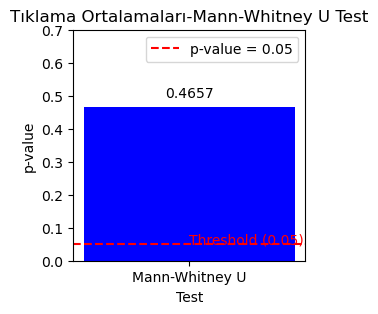

In [894]:
#Mann Whitney U Testi- p_value için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Mann-Whitney U']
p_values = [cr_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Tıklama Ortalamaları-Mann-Whitney U Test')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.7)
plt.legend()
plt.show()

p-value = 0.4657>0.05 olduğundan H0 reddedilemez.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Yeşil bere görseli ile sarı bere görseli tıklanma ortalamaları arasında fark yoktur.

##### %95 güvenle yeşil bere ve sarı bere görsellerine tıklanma ortalamaları arasında istatistiksel olarak anlamlı bir fark yoktur.

#### 2.HİPOTEZ TESTİ: SATIN ALMA/PURCHASE ORTALAMALARI

Hipotez testlerimizi H0-fark yoktur ve H1-fark vardır üzerinden oluşturalım.

H0 : M1 = M2 Yeşil bere görseli ile sarı bere görseli ile satın alma ortalamaları arasında fark yoktur.

H1 : M1!= M2 Yeşil bere ile sarı bere görseli ile satın alma ortalamaları arasında fark vardır.

##### 2.1.NORMALLİK VARSAYIMI(SHAPIRO-WILK TESTİ)

H0 : Normal dağılım varsayımı sağlanmaktadır.

H1 : Normal dağılım varsayımı sağlanmamaktadır.

In [604]:
#Shapiro-Wilk Testi
test_stat, greenp_pvalue = shapiro(green_data["purchase_count"])
print('Green_Test Stat = %.4f, green_p-value = %.4f' % (test_stat, greenp_pvalue)) 
test_stat, yellowp_pvalue = shapiro(yellow_data["purchase_count"])
print('Yellow_Test Stat = %.4f, yellow_p-value = %.4f' % (test_stat, yellowp_pvalue))

Green_Test Stat = 0.9348, green_p-value = 0.0032
Yellow_Test Stat = 0.9292, yellow_p-value = 0.0018


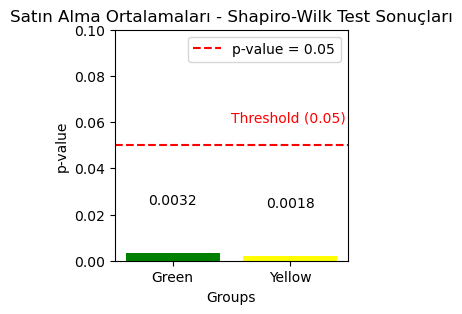

In [914]:
#Shapiro-Wilk Testi p_value değerleri için Bar Grafiği
groups = ['Green', 'Yellow']
p_values = [greenp_pvalue, yellowp_pvalue]
plt.figure(figsize=(3, 3))
bars = plt.bar(groups, p_values, color=['green', 'yellow'])
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.title('Satın Alma Ortalamaları - Shapiro-Wilk Test Sonuçları')
plt.ylabel('p-value')
plt.xlabel('Groups')
plt.text(0.5, 0.06, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

green_p-value = 0.0032<0.05 olduğunda H0 reddedilir.

yellow_p-value = 0.0018<0.05 olduğundan H0 reddedilir.

Normal dağılım varsayımı sağlanmamaktadır. Bu nedenle, varyans homojenliğine bakmaya gerek yoktur.

Whitney U testi yapılmasına karar verilir.

In [912]:
#Mann Whitney U Testi
test_stat, pr_pvalue = stats.mannwhitneyu(green_data["purchase_count"],
                              yellow_data["purchase_count"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pr_pvalue))

Test Stat = 1700.0000, p-value = 0.5970


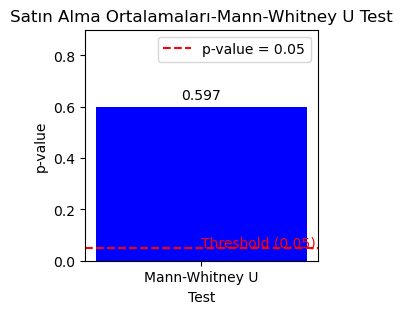

In [626]:
#Mann Whitney U Testi- p_value değeri için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Mann-Whitney U']
p_values = [pr_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Satın Alma Ortalamaları-Mann-Whitney U Test')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.9)
plt.legend()
plt.show()

p-value = 0.5970>0.05 olduğundan H0 reddedilemez. 

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Yeşil bere görseli ile sarı bere görseli ile satın alma ortalamaları arasında fark yoktur.

#####  %95 güvenle yeşil bere ve sarı bere görselleri ile satın alma ortalamaları arasında istatistiksel olarak anlamlı bir fark yoktur.

#### 3.HİPOTEZ TESTİ: KAZANÇ/GELİR ORTALAMALARI

Hipotez testlerimizi H0-fark yoktur ve H1-fark vardır üzerinden oluşturalım.

H0 : M1 = M2 Yeşil bere ile sarı bereden elde edilen gelir ortalamaları arasında fark yoktur.

H1 : M1!= M2 Yeşil bere ile sarı bereden elde edilen gelir ortalamaları arasında fark vardır.


##### 3.1.NORMALLİK VARSAYIMI(SHAPIRO-WILK TESTİ)

H0 : Normal dağılım varsayımı sağlanmaktadır.

H1 : Normal dağılım varsayımı sağlanmamaktadır.

In [905]:
#Shapiro-Wilk Testi
test_stat, gr_pvalue = shapiro(green_data["avg_revenue(euro)"])
print('Green_Test Stat = %.4f, green_p-value = %.4f' % (test_stat, gr_pvalue)) 
test_stat, yl_pvalue = shapiro(yellow_data["avg_revenue(euro)"])
print('Yellow_Test Stat = %.4f, yellow_p-value = %.4f' % (test_stat, yl_pvalue))

Green_Test Stat = 0.9339, green_p-value = 0.0029
Yellow_Test Stat = 0.9825, yellow_p-value = 0.5419


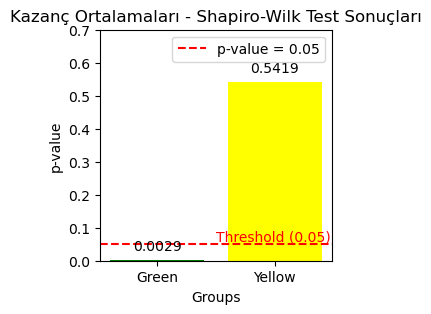

In [907]:
#p_value değerleri için Bar Grafiği
groups = ['Green', 'Yellow']
p_values = [gr_pvalue, yl_pvalue]
plt.figure(figsize=(3, 3))
bars = plt.bar(groups, p_values, color=['green', 'yellow'])
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.title('Kazanç Ortalamaları - Shapiro-Wilk Test Sonuçları')
plt.ylabel('p-value')
plt.xlabel('Groups')
plt.text(0.5, 0.06, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.7)
plt.legend()
plt.show()

green_p-value = 0.0029<0.05 olduğunda H0 reddedilir.

yellow_p-value = 0.5419>0.05 olduğundan H0 reddedilemez.

##### Normal dağılım varsayımı sağlanmamaktadır. Bu nedenle, varyans homojenliğine bakmaya gerek yoktur.

##### Whitney U testi yapılmasına karar verilir.

In [638]:
#Mann Whitney U Testi
test_stat, av_pvalue = stats.mannwhitneyu(green_data["avg_revenue(euro)"],
                              yellow_data["avg_revenue(euro)"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, av_pvalue))

Test Stat = 1661.0000, p-value = 0.4657


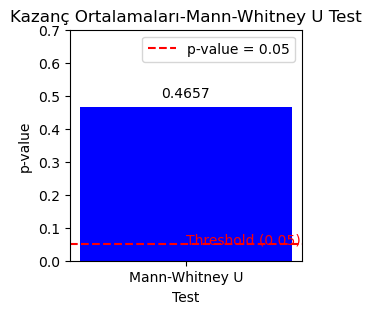

In [910]:
#Mann Whitney U Testi-p_value için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Mann-Whitney U']
p_values = [av_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Kazanç Ortalamaları-Mann-Whitney U Test')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height()  # Barın yüksekliği (p-value)
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 0.7)
plt.legend()
plt.show()

p-value = 0.4657>0.05 olduğundan H0 reddedilemez.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0: Yeşil bere ile sarı bereden elde edilen gelir ortalamaları arasında fark yoktur.

#####  %95 güvenle Yeşil bere ile sarı bereden elde edilen gelir ortalamaları arasında istatistiksel olarak anlamlı bir fark yoktur.

#### AB TEST ORAN KARŞILAŞTIRMA

In [372]:
#İKİ GRUP ORANLARI ARASINDA KARŞILAŞTIRMA YAPMAK İÇİN KULLANILIR. VARSAYIM YOKTUR.
#"Z TESTİ",İKİ VEYA DAHA FAZLA BAĞIMSIZ GRUBUN BAŞARI ORANLARINI HESAPLAMAK İÇİN KULLANILIR.

#### 4.HİPOTEZ TESTİ: SATIN ALMA ORANLARI

H0 : M1 = M2 Yeşil bere ve sarı bere görsellerine tıklamalardan gelen satın alma oranları arasında fark yoktur.

H1 : M1!= M2 Yeşil bere ve sarı bere görsellerine tıklamalardan gelen satın alma oranları arasında fark vardır.

Coversion Rate=Purchase/Click

Tıklama yapanların satın alma oranlarıdır. 

Satın alma sayı toplamının, tıklama sayısı toplamına bölünmesi ile bulunur.

Çıkan sayı 100 ile çarpılarak yüzdelik oran hesaplanır.

##### Coversion Rate için Hesaplama Yapalım

In [407]:
green_click_total= green_data["click_count"].sum()
green_purchase_total=green_data["purchase_count"].sum()
yellow_click_total= yellow_data["click_count"].sum()
yellow_purchase_total=yellow_data["purchase_count"].sum()

In [426]:
green_cr=round((green_purchase_total/green_click_total)*100,2)
yellow_cr=round((yellow_purchase_total/yellow_click_total)*100,2)

In [493]:
print('Yeşil Bere Satın Alma Oranı: %', green_cr,'\n'
     'Sarı Bere Satın Alma Oranı: %', yellow_cr)

Yeşil Bere Satın Alma Oranı: % 66.62 
Sarı Bere Satın Alma Oranı: % 66.38


In [679]:
#Z Testi
test_stat, ztest_pvalue = proportions_ztest(count=[green_purchase_total,yellow_purchase_total],#count: Her grubun başarılı sonuç sayısı (örneğin, satın alma).
                                      nobs=[green_click_total, yellow_click_total]) #nobs: Her grubun toplam deneme sayısı (örneğin, tıklama sayısı).
print('Test Stat = %.4f, p-value = %.4f' % (test_stat,ztest_pvalue))

Test Stat = 0.1040, p-value = 0.9172


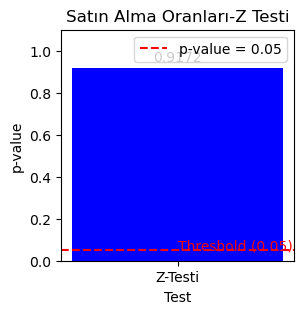

In [924]:
#Z testi- p_value değeri için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Z-Testi']
p_values = [ztest_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Satın Alma Oranları-Z Testi')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

p-value = 0.9172>0.05 olduğundan H0 reddedilemez.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Yeşil bere ve sarı bere görsellerine tıklamalardan gelen satın alma oranları arasında fark yoktur.

#####  %95 güvenle yeşil bere ve sarı bere satın alma oranları arasında istatistiksel olarak anlamlı bir fark yoktur.

#### 5.HİPOTEZ TESTİ: KAZANÇ ORANLARI

H0 : M1 = M2 Yeşil bere ve sarı bere görsellerine tıklamalardan gelen kazanç oranları arasında fark yoktur.

H1 : M1!= M2 Yeşil bere ve sarı bere görsellerine tıklamalardan gelen kazanç oranları arasında fark vardır.

Click Through Rate=Avg. Revenue Sayısı / Click

Görsellere tıklanarak kazanılan gelir/kazanç oranlarıdır.

Geliri ifade eden satır sayısı (satın alma sayısı), toplam tıklama/click sayısına bölünür.

Çıkan sayı 100 ile çarpılarak yüzdelik oran bulunur.



#### Click Trough Rate değeri için ilgili hesaplamaları yapalım

In [436]:
green_rev_count=green_data["avg_revenue(euro)"].count()
green_click_total= green_data["click_count"].sum() #yukarıda hesaplamıştık. Hesaplama için bu değeri yine kullanacağız.
yellow_rev_count=yellow_data["avg_revenue(euro)"].count()
yellow_click_total= yellow_data["click_count"].sum() #Yukarıda hesaplamıştık. Hesaplama için bu değeri yine kullanacağız.

In [448]:
green_click_tr_rate = round((green_rev_count/green_click_total)*100,2)
yellow_click_tr_rate= round((yellow_rev_count/yellow_click_total)*100,2)

In [446]:
print('Yeşil Bereden Elde Edilen Kazanç Oranı: %', green_click_tr_rate,'\n'
     'Sarı Bereden Elde Edilen Kazanç Oranı: %', yellow_click_tr_rate)

Yeşil Bereden Elde Edilen Kazanç Oranı: % 7.64 
Sarı Bereden Elde Edilen Kazanç Oranı: % 7.42


In [928]:
#Z Testi
test_stat, zp_pvalue = proportions_ztest(count=[green_rev_count,yellow_rev_count],#count: Her grubun başarılı sonuç sayısı (örneğin, satın alma).
                                      nobs=[green_click_total, yellow_click_total]) #nobs: Her grubun toplam deneme sayısı (örneğin, tıklama sayısı).
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, zp_pvalue))

Test Stat = 0.1715, p-value = 0.8638


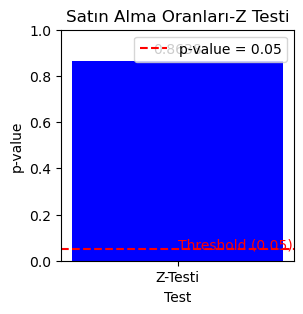

In [930]:
#Z testi- p_value değeri için Bar Grafiği
plt.figure(figsize=(3,3))
groups = ['Z-Testi']
p_values = [zp_pvalue]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Satın Alma Oranları-Z Testi')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()

p-value = 0.8638>0.05 olduğundan H0 reddedilemez.

##### Belirlediğimiz hipotez tezlerine göre,

##### H0 : M1 = M2 Yeşil bere ve sarı bere görsellerine tıklamalardan gelen kazanç oranları arasında fark yoktur.

#####  %95 güvenle eşil bere ve sarı bere görsellerine tıklamalardan gelen kazanç oranları arasında istatiksel olarak anlamlı bir fark yoktur.

## NOT:

#### AB TEST ORTALAMA KARŞILAŞTIRMA

In [806]:
# İKİ GRUP FARKLILIKLARINI KARŞILAŞTIRMAK İÇİN "BAĞIMSIZ ÖRNEKLEM T TESTİ" YA DA  "MANN WHITNEY U TESTI" KULLANILIR.
# "BAĞIMSIZ ÖRNEKLEM T TESTİ"İÇİN 2 VARSAYIMIN SAĞLANMASI GEREKMEKTEDİR. BU VARSAYIMLAR:

# 1.Varsayım: "Normallik Varsayımı"--Verilerin normal dağılıma uygun olması anlamına gelir. 
# Normal dağılım, çan eğrisi olarak bilinen simetrik bir dağılım şeklidir.
# Saphiro-Wilk Testi ile kontrol edilir.

# 2.Varsayım "Varyans Homojenliği Varsayımı"--Farklı gruplardaki verilerin varyanslarının (dağılımlarının) eşit olması anlamına gelir. 
# Gruplar arasındaki değişkenlik benzer olmalıdır.
# Levene Testi ile kontrol edilir.

## EĞER NORMALLİK VARSAYIMI SAĞLANMIYORSA, DİREKT MANN WHITNEY U TESTI KULLANILIR.
## EĞER NORMALLİK VARSAYIMI SAĞLANIYORSA, HOMOJENLİK VARSAYIMINA GEÇİLİR. 
                                          #EĞER VARYANS HOMOJENLİĞİ SAĞLANIYORSA, "BAĞIMSIZ ÖRNEKLEM T TESTİ" KULLANILIR.
                                          #EĞER VARYANS HOMOJENLİĞİ SAĞLANMIYORSA,"BAĞIMSIZ ÖRNEKLEM T TESTİ-(WELCH)" KULLANILIR.

Yukarıdaki örnekte her iki değerde aynı anda normallik dağılımı şartı sağlanamadığı için varyans homojenliği yapılamadı.
Bu nedenle, varyans homojenliğini incelemek için aşağıdaki örneğe bakalım:

Örnek, sadece varyans homojenliği uygulaması ve sonuçta hipotez doğruluğu için kullanılmaya karar verilecek test kararının nasıl olduğu ile ilgilidir. Tam bir örneklemi yansıtamamakla beraber gerçek değerlerden oluşmamaktadır. 

#### Rastgele Değerlerden bir Dataframe oluşturalım:

In [737]:
green_purchase_count_datas = [665, 315, 458, 487, 441, 519, 512, 747]
df_g = pd.DataFrame(green_purchase_count_datas, columns=['purchase_count'])

yellow_purchase_count_datas = [702, 834, 422, 429, 749, 778, 491]
df_y = pd.DataFrame(yellow_purchase_count_datas, columns=['purchase_count'])

#### HİPOTEZ TESTİ: SATIN ALMA  ORTALAMALARI

H0 : M1 = M2 Yeşil bere görseli ile sarı bere görseli ile satın alma ortalamaları arasında fark yoktur.

H1 : M1!= M2 Yeşil bere ve sarı bere görseli ile satın alma ortalamaları arasında fark vardır.


##### NORMALLİK VARSAYIMI(SHAPIRO-WILK TESTİ)

H0 : Normal dağılım varsayımı sağlanmaktadır.

H1 : Normal dağılım varsayımı sağlanmamaktadır.

In [769]:
green_test_stat, df_green_p_value = shapiro(df_g["purchase_count"])
yellow_test_stat, df_yellow_p_value = shapiro(df_y["purchase_count"])

print('Green_Test Stat = %.4f, green_p-value = %.4f' % (green_test_stat, df_green_p_value))
print('Yellow_Test Stat = %.4f, yellow_p-value = %.4f' % (yellow_test_stat, df_yellow_p_value))

Green_Test Stat = 0.9426, green_p-value = 0.6367
Yellow_Test Stat = 0.8561, yellow_p-value = 0.1397


green_p-value = 0.6367>0.05 olduğundan H0 reddedilemez.

H0 : Normal dağılım varsayımı sağlanmaktadır.

yellow_p-value = 0.1397 >0.05 olduğundan H0 reddedilemez.

H0 : Normal dağılım varsayımı sağlanmaktadır.

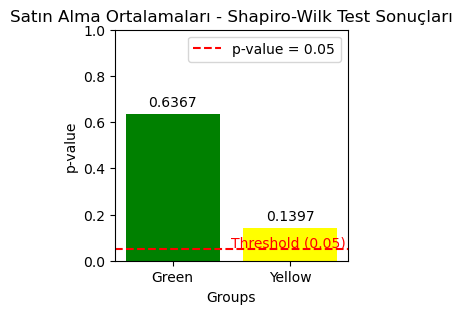

In [817]:
groups = ['Green', 'Yellow']
p_values = [df_green_p_value, df_yellow_p_value]
plt.figure(figsize=(3, 3))
bars = plt.bar(groups, p_values, color=['green', 'yellow'])
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.title('Satın Alma Ortalamaları - Shapiro-Wilk Test Sonuçları')
plt.ylabel('p-value')
plt.xlabel('Groups')
plt.text(0.5, 0.06, 'Threshold (0.05)', color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()

Her iki değer için normallik varsayımı sağlandığı için varyans homojenliği varsayımı kontrol edilir. Bunun için,"LEVENE TESTİ" uygulanır.
Bu test sonucuna göre, "BAĞIMSIZ ÖRNEKLEM T TESTİ" ya da "BAĞIMSIZ ÖRNEKLEM T TESTİ-welch" uygulanmasına karar verilir.

#### VARYANS HOMOJENLİĞİ VARSAYIMI (LEVENE TESTİ)

H0: Varyanslar Homojendir.

H1: Varyanslar Homojen Değildir.

In [790]:
test_stat, vy_pvalue = levene(df_g["purchase_count"],
                           df_y["purchase_count"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, vy_pvalue))

Test Stat = 1.0088, p-value = 0.3335


p-value = 0.3335>0.05 olduğundan H0 reddilemez . Varyans homojenliği sağlanmıştır. 

Varyans Homojenliği sağlandığı için "BAĞIMSIZ ÖRNEKLEM T TESTİ" uygulanır.

In [794]:
test_stat, df_gy_pvalue = ttest_ind(df_g['purchase_count'],
                              df_y['purchase_count'],
                              equal_var=True)  # varyans homojenliği olmasaydı, "equal_var=False" yapmamız gerekirdi. BAĞIMSIZ ÖRNEKLEM T TESTİ-welch testi kullanmış olurduk.

In [798]:
df_gy_pvalue 

0.18823050184905096

0.188>0.05 olduğundan H0 reddedilemez. 
H0 : M1 = M2 Yeşil bere görseli ile sarı bere görseli ile satın alma ortalamaları arasında fark yoktur.

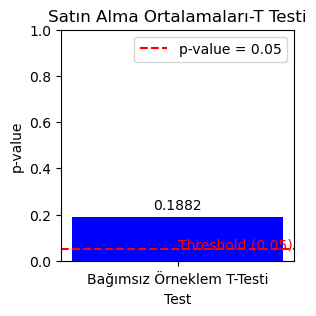

In [819]:
plt.figure(figsize=(3,3))
groups = ['Bağımsız Örneklem T-Testi']
p_values = [df_gy_pvalue ]
bars = plt.bar(groups, p_values, color='blue')
plt.bar(groups, p_values, color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('Satın Alma Ortalamaları-T Testi')
plt.ylabel('p-value')
plt.xlabel('Test')
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')
plt.text(0, 0.052, 'Threshold (0.05)', color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()